# initialisation

In [1]:
import backproject
import numpy as np
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import glob
import cv2
import torch
from sklearn.cluster import KMeans
import os

# TODO intrinsics write, Depth check more consistent? Kmeans for prompts

In [2]:
import glob
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
def make_gif(frame_folder):
    frames = [Image.open(image) for image in sorted(glob.glob(f"{frame_folder}/*.png"))]
    print(frames)
    frame_one = frames[0]
    frame_one.save(os.path.join(frame_folder, 'gif.gif'), format="GIF", append_images=frames,
               save_all=True, duration=400, loop=0)

In [3]:
#RoomName = "office2"
#path_to_traj = f"/home/rozenberszki/project/wsnsl/Datasets/Replica/room0/traj.txt"
#T_wc = np.loadtxt(path_to_traj).reshape(-1, 4, 4)

#path_to_traj = f"/home/rozenberszki/project/wsnsl/Datasets/Scannet++/data/56a0ec536c/iphone/processedData/traj.txt"
path_to_traj = f"/home/rozenberszki/D_Project/wsnsl/Dataset/traj.txt"
T_wc = np.loadtxt(path_to_traj).reshape(-1, 4, 4)
print(T_wc[0])
#s = np.ones((4, 4))
'''s=np.array([[1, 1, -1, 1],
            [1, 1, -1, 1],
            [-1, -1, 1, -1],
            [0, 0, 0, 1]])
T_wc = s * T_wc'''
T_wc[:,1:3]*=-1
#T_wc[:,:3,3]=0
color_paths = sorted(glob.glob(f"/home/rozenberszki/D_Project/wsnsl/Dataset/color_path/*.jpg"))
print(color_paths)
depth_paths = sorted(glob.glob(f"/home/rozenberszki/D_Project/wsnsl/Dataset/color_path/*.png"))
#  y,z 
T_wc[:,:3, 3] *= 1/2
print(T_wc[0])


[[ 0.63281906  0.5936474  -0.4971145   0.39389375]
 [ 0.03214595 -0.6616073  -0.7491611   0.06876414]
 [-0.7736321   0.45810315 -0.43776107  0.6076599 ]
 [ 0.          0.          0.          1.        ]]
['/home/rozenberszki/D_Project/wsnsl/Dataset/color_path/frame_000000.jpg', '/home/rozenberszki/D_Project/wsnsl/Dataset/color_path/frame_000001.jpg', '/home/rozenberszki/D_Project/wsnsl/Dataset/color_path/frame_000002.jpg', '/home/rozenberszki/D_Project/wsnsl/Dataset/color_path/frame_000003.jpg', '/home/rozenberszki/D_Project/wsnsl/Dataset/color_path/frame_000004.jpg', '/home/rozenberszki/D_Project/wsnsl/Dataset/color_path/frame_000005.jpg', '/home/rozenberszki/D_Project/wsnsl/Dataset/color_path/frame_000006.jpg', '/home/rozenberszki/D_Project/wsnsl/Dataset/color_path/frame_000007.jpg', '/home/rozenberszki/D_Project/wsnsl/Dataset/color_path/frame_000008.jpg', '/home/rozenberszki/D_Project/wsnsl/Dataset/color_path/frame_000009.jpg', '/home/rozenberszki/D_Project/wsnsl/Dataset/color_path

In [4]:
'''
for i in range(20):
    color_path = color_paths[i*50]
    color_data = cv2.imread(color_path)
    image = cv2.cvtColor(color_data, cv2.COLOR_BGR2RGB)
    masks = mask_generator.generate(image)
    images.append(image)
    masksarr.append(masks)
del sam
'''

'\nfor i in range(20):\n    color_path = color_paths[i*50]\n    color_data = cv2.imread(color_path)\n    image = cv2.cvtColor(color_data, cv2.COLOR_BGR2RGB)\n    masks = mask_generator.generate(image)\n    images.append(image)\n    masksarr.append(masks)\ndel sam\n'

In [5]:
import vis
import matplotlib.pyplot as plt
'''
for i in range(20):
    plt.figure(figsize=(20,20))
    plt.imshow(images[i])
    vis.show_anns(masksarr[i])
    plt.axis('off')
    plt.show() 
    '''
def visualizerForAuto(image, masks):
    plt.figure(figsize=(20,20))
    plt.imshow(image)
    vis.show_anns(masks)
    plt.axis('off')
    plt.show() 
def visualizerWithPrompts(image,masks,prompts):
    plt.figure(figsize=(20,20))
    plt.imshow(image)
    vis.show_anns(masks)
    plt.scatter(prompts[0,:],prompts[1,:],c='r',s=10)
    plt.axis('off')
    plt.show()

In [6]:
images=[]
masksarr=[]

# Helper

In [7]:

def readDepth(filepath):
    depth = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)
    depth_data = depth.astype(np.float32) / 6553.5
    depth_data = torch.from_numpy(depth_data)
    print(depth_data[0,0])
    return depth_data


def checkIfInsideImage(backprojectedSamples, zg, Depthg, border, H,W):
    backprojectedSamples = backprojectedSamples.astype(int)
    # efficient
    # filter out samples outside of image bounds
    condition = (
        (backprojectedSamples[1, :] < 0 + border)
        | (backprojectedSamples[0, :] < 0 + border)
        | (backprojectedSamples[1, :] > H -1 - border)
        | (backprojectedSamples[0, :] > W -1 - border)
    )
    filteredIndices = np.where(condition)
    filteredBackProj = backprojectedSamples[:, ~condition]
    depthg = np.array(Depthg[filteredBackProj[1, :], filteredBackProj[0, :]])
    zg = np.delete(zg, filteredIndices)
    depthCheck = depthg - zg

    # print(f'depthCkeck, smaller 0.005: {np.count_nonzero(abs(depthCheck) < 0.005)}, depthCheck, smaller 0.01: {np.count_nonzero(abs(depthCheck) < 0.01)}, smaller 0.1: {np.count_nonzero(abs(depthCheck) < 0.1)}')
    #print("depthCheck",depthCheck)
    indices = np.where(abs(depthCheck) < 0.5)
    filteredBackProj = filteredBackProj[:, indices]
    '''
    print(depthCheck)
    print("filteredBackProj",filteredBackProj.shape)
    #tmp=filteredBackProj[:,filteredBackProj[2,:,:]==12]
    indices=np.where(filteredBackProj[2,:,:]==12)
    print(depthCheck)
    print("max Real")
    print(max(depthg))
    print(min(depthg))
    print("max Mine")
    print(max(zg))
    print(min(zg))
    '''
    return filteredBackProj

def generateIds(masks, min_area=1000):
    """sortedMasks = sorted(masks, key=(lambda x: x["area"]), reverse=True)
    ids = np.ones(
        (
            sortedMasks[0]["segmentation"].shape[0],
            sortedMasks[0]["segmentation"].shape[1],
            1,
        )
    )
    # maybe more efficient
    # first frame has 85 instances so not too bad
    for i, ann in enumerate(sortedMasks):
        m = ann["segmentation"]
        idsForEachMask = np.concatenate([[i]])
        ids[m] = idsForEachMask
    return ids.squeeze().astype(np.int32)"""
    sortedMasks = sorted(masks, key=(lambda x: x["area"]), reverse=True)
    if min_area > 0:
        sortedMasks = [mask for mask in sortedMasks if mask["area"] > min_area]
    ids = np.full(
            (sortedMasks[0]["segmentation"].shape[0],
            sortedMasks[0]["segmentation"].shape[1]),
            -100,
        )
    for i, ann in enumerate(sortedMasks):
        m = ann["segmentation"]
        ids[m] = i
    unique_ids,counts = np.unique(ids, return_counts=True)
    for i in range(len(unique_ids)):
        if counts[i] < min_area:
            ids[ids == unique_ids[i]] = -100
    return ids

def sample_from_instances_with_ids_area(ids, numberOfMasks, points_per_instance=1, sampleWithArea=40):
    tensors = []

    temp=np.unique(ids)[1:]
    for i,element in enumerate(list(temp.astype(int))):
        if element >=0:            
            '''labels = np.where(ids == element).astype(np.int8)
            kernel = np.ones((7, 7), np.uint8)
            labels= cv2.erode(labels.astype(np.uint8), kernel, iterations=1)
            '''
            mask= ids==element
            '''if element==12:
                plt.imshow(mask)
                plt.show()'''
            kernel = np.ones((10, 10), np.uint8)
            mask= cv2.erode(mask.astype(np.uint8), kernel, iterations=1)
            '''if element==12:
                plt.imshow(mask)
                plt.show()'''
            labels = np.where(mask)
            indices = list(zip(labels[0], labels[1]))
            points_per_instance= len(indices)
            #points_per_instance=int(2*np.log2(points_per_instance))
            points_per_instance=2*points_per_instance//(sampleWithArea**2)
            if len(indices) > points_per_instance and len(indices)>1 and points_per_instance>1:  # Check if there are any True pixels
                sampled_indices = np.linspace(0, len(indices)-1, points_per_instance, dtype=int)
                sampled_tensor = torch.tensor([indices[j][::-1] for j in sampled_indices]).T
                element_tensor = torch.full((sampled_tensor.shape[1],), element)
                
                element_tensor = element_tensor.unsqueeze(0)
                
                tensors.append(torch.cat((sampled_tensor, element_tensor), axis=0))

    torch_sampled_indices = torch.cat(tensors, axis=1)
    return torch_sampled_indices.to(torch.int32)

In [8]:

print(T_wc[0])
a=readDepth(depth_paths[0])
print(a[0,0])
print(T_wc[1])
print(T_wc[5])

[[ 0.63281906  0.5936474  -0.4971145   0.19694687]
 [-0.03214595  0.6616073   0.7491611  -0.03438207]
 [ 0.7736321  -0.45810315  0.43776107 -0.30382995]
 [ 0.          0.          0.          1.        ]]
tensor(0.8171)
tensor(0.8171)
[[ 0.63435626  0.5931439  -0.4957543   0.1967111 ]
 [-0.03307265  0.66154075  0.7491795  -0.03420448]
 [ 0.77233297 -0.45885086  0.4392694  -0.3038482 ]
 [ 0.          0.          0.          0.99999994]]
[[ 0.6391145   0.5957699  -0.48640606  0.19659261]
 [-0.03439033  0.6539301   0.7557729  -0.03473712]
 [ 0.7683423  -0.4662978   0.43842497 -0.3041142 ]
 [ 0.          0.          0.          1.        ]]


In [9]:

def plot(samples):
    data = samples.copy()
    #data = data[:, data[1] > -2]
    #data = data[:, data[1] > -2]
    x = data[0]
    y = data[1]
    z = data[2] * -1
    labels = data[3]

    # Create a scatter plot
    fig = plt.figure()
    fig.set_size_inches(4100, 4100)
    ax = fig.add_subplot(111, projection="3d")
    ax = fig.add_subplot(111, projection="3d")

    # Plot each point with a color corresponding to its label
    unique_labels = np.unique(labels)
    for label in unique_labels:
        indices = np.where(labels == label)
        ax.scatter(x[indices], y[indices], z[indices], s=3)

    # Set axis labels
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    #ax.set_ylim((-2, 2))
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    #ax.set_ylim((-2, 2))
    # Add a legend
    ax.legend()

    # Show the plot
    plt.show()

In [10]:
sam_checkpoint = '/home/rozenberszki/project/wsnsl/sam/sam_vit_h_4b8939.pth'
model_type = "vit_h"


sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device="cuda")


mask_generator = SamAutomaticMaskGenerator(
    sam, points_per_side=16, pred_iou_thresh=0.9, stability_score_thresh=0.9, crop_nms_thresh=0.2,box_nms_thresh=0.4,crop_n_layers=0, crop_n_points_downscale_factor=2, min_mask_region_area=10000)
#crop_n_layers (int): If >0, mask prediction will be run again on
#crops of the image. Sets the number of layers to run, where each
 #layer has 2**i_layer number of image crops.
 #crop_nms_thresh (float): The box IoU cutoff used by non-maximal suppression to filter duplicate masks between different crops.
"""

  mask_generator = SamAutomaticMaskGenerator(
    sam, points_per_side=16, pred_iou_thresh=0.9, stability_score_thresh=0.9, crop_nms_thresh=0.2,box_nms_thresh=0.4,crop_n_layers=0, crop_n_points_downscale_factor=2, min_mask_region_area=10000)
        Using a SAM model, generates masks for the entire image.
        Generates a grid of point prompts over the image, then filters
        low quality and duplicate masks. The default settings are chosen
        for SAM with a ViT-H backbone.

        Arguments:
          model (Sam): The SAM model to use for mask prediction.
          points_per_side (int or None): The number of points to be sampled
            along one side of the image. The total number of points is
            points_per_side**2. If None, 'point_grids' must provide explicit
            point sampling.
          points_per_batch (int): Sets the number of points run simultaneously
            by the model. Higher numbers may be faster but use more GPU memory.
          pred_iou_thresh (float): A filtering threshold in [0,1], using the
            model's predicted mask quality.
          stability_score_thresh (float): A filtering threshold in [0,1], using
            the stability of the mask under changes to the cutoff used to binarize
            the model's mask predictions.
          stability_score_offset (float): The amount to shift the cutoff when
            calculated the stability score.
          box_nms_thresh (float): The box IoU cutoff used by non-maximal
            suppression to filter duplicate masks.
          crop_n_layers (int): If >0, mask prediction will be run again on
            crops of the image. Sets the number of layers to run, where each
            layer has 2**i_layer number of image crops.
          crop_nms_thresh (float): The box IoU cutoff used by non-maximal
            suppression to filter duplicate masks between different crops.
          crop_overlap_ratio (float): Sets the degree to which crops overlap.
            In the first crop layer, crops will overlap by this fraction of
            the image length. Later layers with more crops scale down this overlap.
          crop_n_points_downscale_factor (int): The number of points-per-side
            sampled in layer n is scaled down by crop_n_points_downscale_factor**n.
          point_grids (list(np.ndarray) or None): A list over explicit grids
            of points used for sampling, normalized to [0,1]. The nth grid in the
            list is used in the nth crop layer. Exclusive with points_per_side.
          min_mask_region_area (int): If >0, postprocessing will be applied
            to remove disconnected regions and holes in masks with area smaller
            than min_mask_region_area. Requires opencv.
          output_mode (str): The form masks are returned in. Can be 'binary_mask',
            'uncompressed_rle', or 'coco_rle'. 'coco_rle' requires pycocotools.
            For large resolutions, 'binary_mask' may consume large amounts of
            memory.
        """
currFramenumber=0

# Code

In [11]:

def createFrontMappingAutosort(
    curr_frame_number,
    T,
    K,
    depths,
    automaticMask,
    max_id=None,
    current_frame=None,
    samples=None,
    smallesMaskSize=1000,
    border=0,
    verbose=False,
    followedInstance=12,
):
    visualizerForId=vis.visualizerForIds()
    print("current image",curr_frame_number)
    
    if curr_frame_number==0:
        masks = automaticMask.generate(current_frame)
        ids = generateIds(masks, min_area=smallesMaskSize)
        #idler sortlancak
        if verbose:
            plt.figure(figsize=(10,10))
            plt.imshow(current_frame)
            vis.show_anns(masks)
            plt.axis('off')
            #plt.savefig(os.path.join("/home/koerner/Project_Dogu/wsnsl/output/Own/room0/segmentation", f'{curr_frame_number}_{0}_mask_{curr_frame_number}_{-1}.png'))
            plt.show()
        max_id = ids.max()+1
        samplesFromCurrent = sample_from_instances_with_ids_area(
            ids, max_id, points_per_instance=1000
        )
        '''if verbose:
            visualizerForId.visualizer(anns=ids, path = "/home/rozenberszki/D_Project/wsnsl/output/Own/segmentationScannet/frame_".zfill(6), prompts=samplesFromCurrent[:, samplesFromCurrent[2, :] == followedInstance])'''

        realWorldSamples = backproject.realWorldProject(
            samplesFromCurrent[:2, :],
            T_wc[0],
            K,
            readDepth(depth_paths[0]),
        )
        realWorldSamples = np.concatenate(
            (realWorldSamples, samplesFromCurrent[2:, :]), axis=0
        )
        
        print("First iter unique",len(np.unique(ids)))
        visualizerForId.visualizer(anns=ids, path = None)

        return ids, realWorldSamples, max_id

    
    mask = mask_generator.generate(current_frame)
    # TODO suna bakilcak
    ids = generateIds(mask, min_area=smallesMaskSize)
    current_unique_ids=np.unique(ids)

    T_current = T[curr_frame_number]
    
    depthf = readDepth(depths[curr_frame_number])
    
    frontProjectedSamples, projDepth = backproject.camProject(samples, T_current, K)
      
    frontProjectedSamples = checkIfInsideImage(
        frontProjectedSamples, projDepth, depthf, border=border, H=depthf.shape[0], W=depthf.shape[1]
    )
    mask = mask_generator.generate(current_frame)
    # TODO suna bakilcak
    ids = generateIds(mask, min_area=smallesMaskSize)
    current_unique_ids=np.unique(ids)
   
    '''if verbose:
        visualizerForId.visualizer(anns=ids, path = None)
    '''
    """ 
    # Projected everything onto the current frame
    # Now for each sample project on to the image and check if it is inside the each mask instance
    # on to the each currentMask take majority of the samples and assign to the mask
    # some are pruned do not take the max_id into account
    """

    if frontProjectedSamples.ndim == 3:
        frontProjectedSamples = frontProjectedSamples.reshape(3, -1)

    copyOfIds = np.full(ids.shape, -100)
    '''if verbose:
        visualizerForId.visualizer(anns=ids, path = "/home/rozenberszki/D_Project/wsnsl/output/Own/segmentationScannet", prompts=frontProjectedSamples[:, frontProjectedSamples[2, :] == followedInstance])'''
    for currentMaskId in current_unique_ids:
        if currentMaskId < 0:
            continue
        currentMask= ids == currentMaskId
        dictOfIds = {-100: -100}
        for instance in np.unique(frontProjectedSamples[2, :]):
            if instance >= 0:
                samplesInside= frontProjectedSamples[:, frontProjectedSamples[2, :] == instance]
                
                insideTheMask= currentMask[samplesInside[1, :] , samplesInside[0, :]]
                dictOfIds[instance] = np.sum(insideTheMask)
                
        maxForMask= max(dictOfIds, key=dictOfIds.get)
        ###########################################
        insideTheMask= currentMask[frontProjectedSamples[1, :] , frontProjectedSamples[0, :]]
        if maxForMask != -100 and dictOfIds[maxForMask] > 0.4 * np.sum(insideTheMask) and np.sum(insideTheMask) > 2:
            copyOfIds[ids==currentMaskId ] = maxForMask
        elif maxForMask != -100:
            copyOfIds[ ids==currentMaskId ] = max_id
            max_id += 1
            #print("CHANGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEED NOT SEEEEEEEEEEEEEEEN")
    if verbose:
        visualizerForId.visualizer(anns=copyOfIds, path = "/home/rozenberszki/D_Project/wsnsl/output/Own/segmentationScannet", prompts=frontProjectedSamples[:, frontProjectedSamples[2, :] == followedInstance])
        #print("The Found Projection instance",maxForMask)
        #print("Mapping",dictOfIds[followedInstance])
        #print("MaxId",max_id)
        
    ids=copyOfIds
    
    if border != 0:
        ids[0 : 2 * border] = -100
        ids[-2 * border :] = -100
        ids[:, 0 : 2 * border] = -100
        ids[:, -2 * border :] = -100
    
    numberOfMasks = len(np.unique(ids))

    # TODO sample a7.5ccording to the areas of the masks
    samplesFromCurrent = sample_from_instances_with_ids_area(
        ids, numberOfMasks, points_per_instance=100
    )
    # 3d
    realWorldProjectCurr = backproject.realWorldProject(
        samplesFromCurrent[:2, :], T[curr_frame_number], K, depthf
    )
    #print("Current pose ", T[curr_frame_number])
    # add the ids
    realWorldProjectCurr = np.concatenate(
        (realWorldProjectCurr, samplesFromCurrent[2:, :]), axis=0
    )
    samples = np.concatenate((samples, realWorldProjectCurr), axis=1)
    #max_id = np.max(samples[2:, :])
    #print(samples)
    print("Current unique ids", current_unique_ids)
    if not verbose:
        visualizerForId.visualizer(anns=copyOfIds, path = f"/home/rozenberszki/D_Project/wsnsl/output/Own/segmentationScannet/{str(curr_frame_number).zfill(6)}" )
    #[-100    0    1    2    3    4    5    6    7    8    9   10   11   12 13   14   15   16   17   18   19  20   21   22   23   24   25   26   27   28   29   30   31   32   33]

    return ids, samples, max_id


'''
            visualizerForId.visualizer(anns=ids, path = os.path.join("/home/koerner/Project_Dogu/wsnsl/output/Own/room0/segmentation", f'{curr_frame_number}_{currentMaskId}_mask_{curr_frame_number}_{most_common_instance}.png'), prompts = frontProjectedSamples[:2, filter_most_common])
            '''      

In [12]:
# main loop
samples=None
visu=vis.visualizerForIds()
max_id=0
howManyFrames=10
currFramenumber=0*len(depth_paths)//howManyFrames
color_data = cv2.imread(color_paths[currFramenumber])
image = cv2.cvtColor(color_data, cv2.COLOR_BGR2RGB)
print(image.shape)
print(readDepth(depth_paths[currFramenumber]).shape)

def read_intrinsic(frame):
    intrinsic = np.loadtxt('/home/rozenberszki/D_Project/wsnsl/Dataset/intrinsic.txt').reshape(-1, 3, 3)
    intrinsic = intrinsic[frame]
    intrinsic*=1/2
    print(intrinsic)
    return intrinsic

(720, 960, 3)
tensor(0.8171)
torch.Size([720, 960])


[[7.1453965e+02 0.0000000e+00 4.7727585e+02]
 [0.0000000e+00 7.1453965e+02 3.6147555e+02]
 [0.0000000e+00 0.0000000e+00 5.0000000e-01]]
current image 0


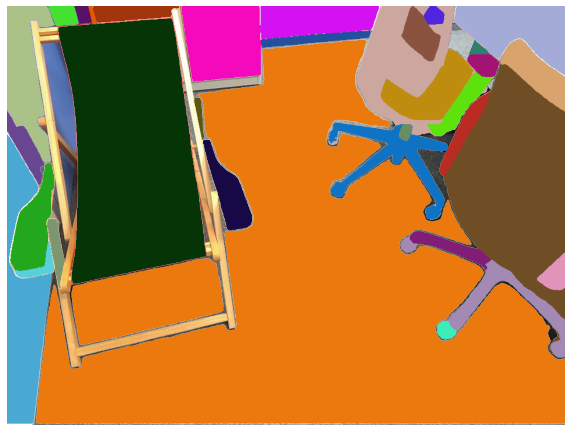

tensor(0.8171)
First iter unique 17
[[7.1451485e+02 0.0000000e+00 4.7729140e+02]
 [0.0000000e+00 7.1451485e+02 3.6151365e+02]
 [0.0000000e+00 0.0000000e+00 5.0000000e-01]]
current image 6
tensor(0.8937)
Current unique ids [-100    0    1    2    3    5    6    7    8    9   11   12   13   14
   15   16]
[[7.14511000e+02 0.00000000e+00 4.77274935e+02]
 [0.00000000e+00 7.14511000e+02 3.61517580e+02]
 [0.00000000e+00 0.00000000e+00 5.00000000e-01]]
current image 12
tensor(0.8244)
Current unique ids [-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14]
[[7.1457795e+02 0.0000000e+00 4.7727610e+02]
 [0.0000000e+00 7.1457795e+02 3.6152150e+02]
 [0.0000000e+00 0.0000000e+00 5.0000000e-01]]
current image 18
tensor(0.8989)
Current unique ids [-100    0    1    2    3    4    5    6    7    8    9   10   11   12
   13   14]
[[7.1453780e+02 0.0000000e+00 4.7723730e+02]
 [0.0000000e+00 7.1453780e+02 3.6148645e+02]
 [0.0000000e+00 0.0000000e+00 5.0000000e-01]]
current im

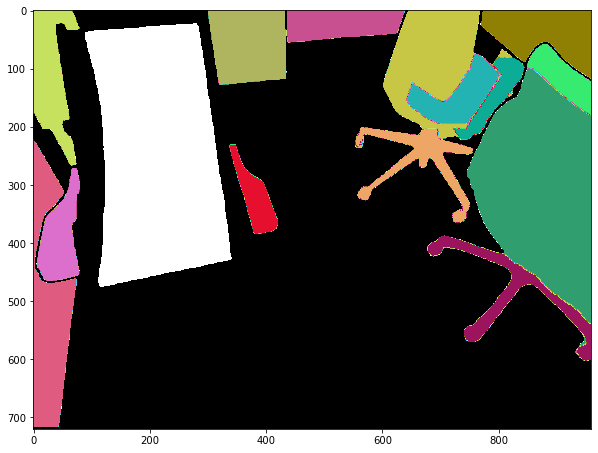

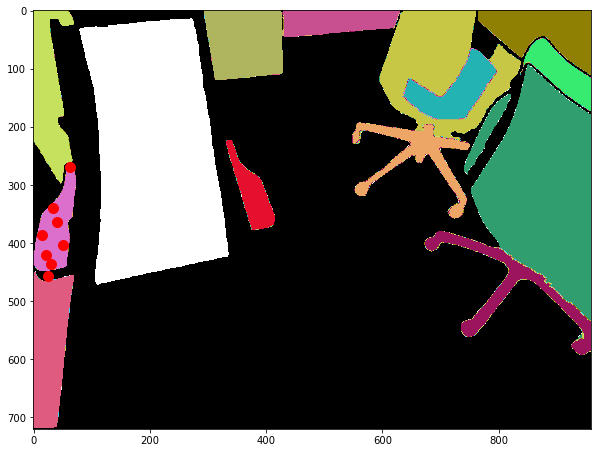

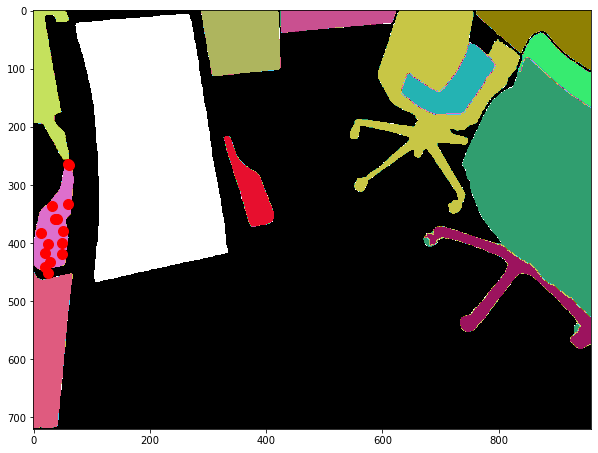

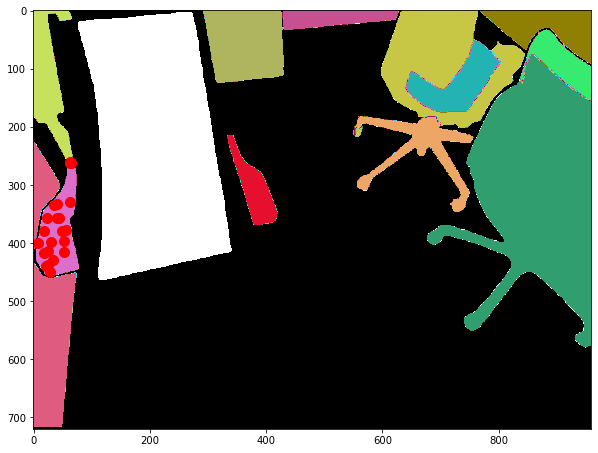

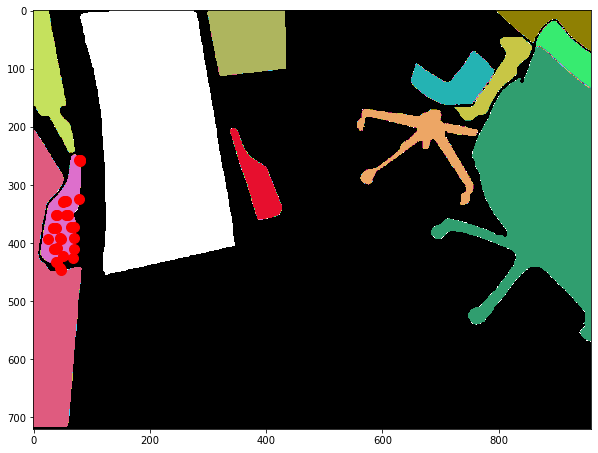

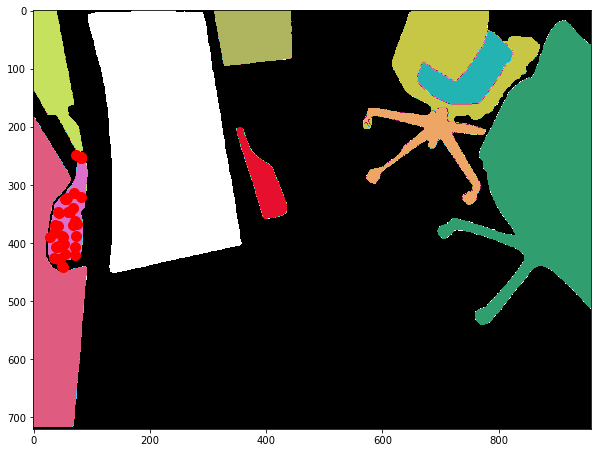

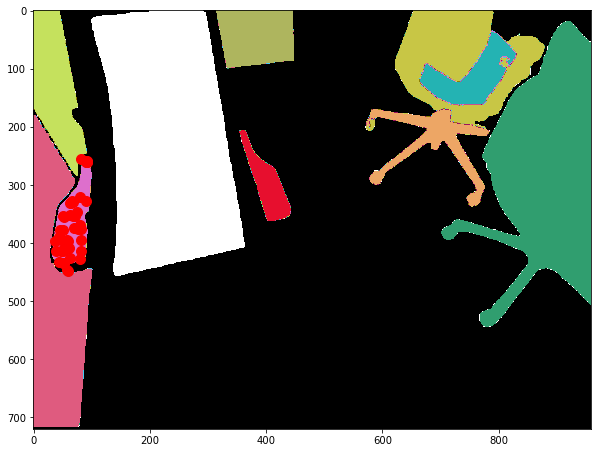

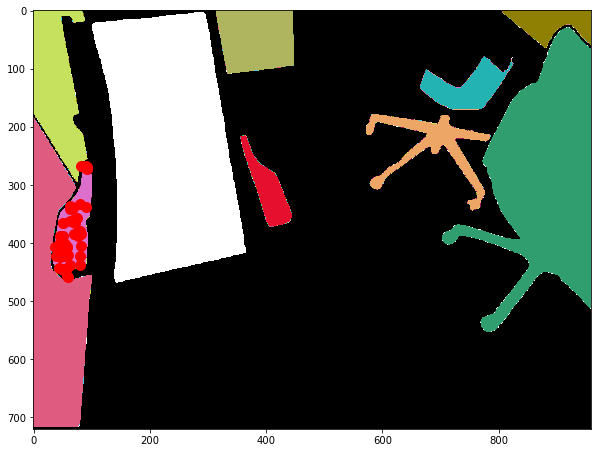

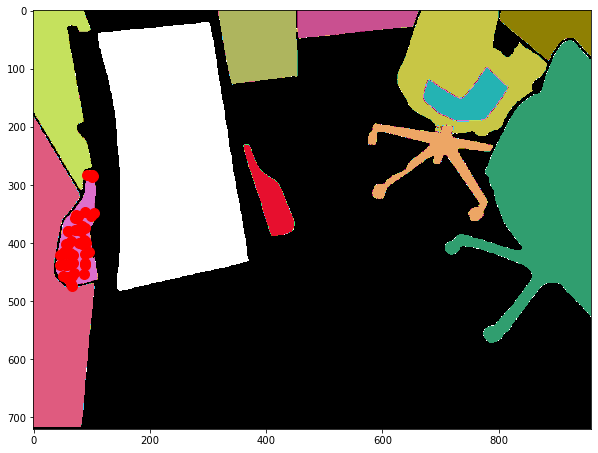

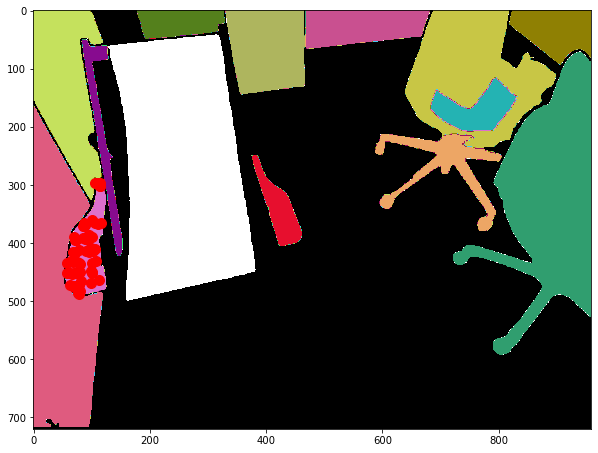

In [13]:
for i in range(0,howManyFrames):
    currFramenumber=i*len(depth_paths)//howManyFrames
    color_data = cv2.imread(color_paths[currFramenumber])
    image = cv2.cvtColor(color_data, cv2.COLOR_BGR2RGB)
    K=read_intrinsic(currFramenumber)#*0.75
    masks, samples, max_id=createFrontMappingAutosort(currFramenumber, T_wc, K, depth_paths, mask_generator, max_id=max_id, smallesMaskSize=10000/2,current_frame=image, samples=samples,verbose=True,followedInstance=12)
    #plot(samples) # 8 12
    #print(i)
torch.cuda.empty_cache()


In [14]:
make_gif(f"/home/rozenberszki/D_Project/wsnsl/output/Own/segmentationScannet")


[<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1000x1000 at 0x7F91000D6A90>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1000x1000 at 0x7F9101C237D0>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1000x1000 at 0x7F91EC8FD690>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1000x1000 at 0x7F90FF97A250>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1000x1000 at 0x7F9101541610>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1000x1000 at 0x7F901C1F1650>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1000x1000 at 0x7F901C1F1E90>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1000x1000 at 0x7F91004FE510>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1000x1000 at 0x7F90FFC18DD0>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1000x1000 at 0x7F90FFC244D0>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1000x1000 at 0x7F90FFF536D0>, <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1000x1000 at 0x7F90FE